In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import scipy
from tqdm import tqdm

import lib

In [2]:
def get_features_bar(im, bar):
  bar_ind_x = int(im.shape[1]/2)

  slice = im[:, bar_ind_x:bar_ind_x+5]  
  slice = np.sum(slice, axis=1).astype(bar.dtype)
  slice /= np.max(slice)
  correlation = np.convolve(slice, bar, 'valid')
  bar_ind_y = np.argmax(correlation)+int(len(bar)/2)-1
  return correlation, bar_ind_y

In [3]:
video_path = 'inputs/PXL_20241228_180630049.mp4'
video_path = 'inputs/PXL_20241228_181110762.mp4'

desired_fps = 7

imgs = lib.sample_video(video_path, desired_fps)

imgs = imgs[40:]

In [4]:
im_background = lib.calculate_background(imgs)
#im_background_2 = lib.calculate_background_2(imgs)

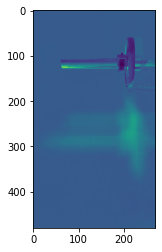

In [5]:
im = imgs[0]

im = lib.remove_background(im, im_background)
im = lib.preprocess(im)

plt.imshow(im)

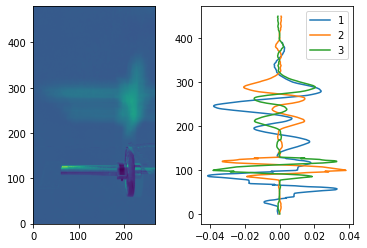

In [6]:
bar_height_guess = 30

bar_1 = -1*np.ones(bar_height_guess)
bar_1 = np.concatenate([-0.5*bar_1, bar_1, -0.5*bar_1])
bar_1 /= len(bar_1)

bar_2 = np.flip(np.linspace(0, 1, bar_height_guess))-0.5
bar_2 /= len(bar_2)

bar_3 = np.linspace(0, 1, bar_height_guess)-0.5
bar_3 /= len(bar_3)

im = imgs[0]

im = lib.remove_background(im, im_background)
im = lib.preprocess(im)


plt.subplot(1, 2, 1)
plt.imshow(im, origin='lower')

plt.subplot(1, 2, 2)
correlation_1, bar_ind_y = get_features_bar(im, bar_1)
plt.plot(correlation_1, np.arange(0, len(correlation_1)), label='1')

correlation_2, bar_ind_y = get_features_bar(im, bar_2)
plt.plot(correlation_2, np.arange(0, len(correlation_2)), label='2')

correlation_3, bar_ind_y = get_features_bar(im, bar_3)
plt.plot(correlation_3, np.arange(0, len(correlation_3)), label='3')
plt.legend()

In [7]:
im.max()

1.0

  0%|          | 0/249 [00:00<?, ?it/s]

100%|██████████| 249/249 [00:04<00:00, 53.82it/s]


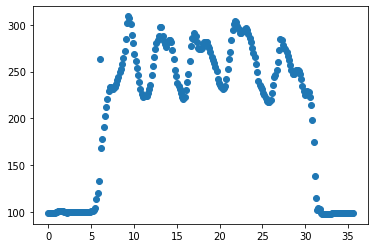

In [8]:
bar_height_guess = 24
bar_heights = []
for im in tqdm(imgs):
  im = lib.remove_background(im, im_background)
  im = lib.preprocess(im)

  correlation, bar_ind_y = get_features_bar(im, bar_2)

  bar_heights.append(np.argmax(correlation))

duration = len(imgs)/desired_fps
t = np.linspace(0, duration, len(bar_heights))
plt.scatter(t, bar_heights)

100%|██████████| 249/249 [00:04<00:00, 58.07it/s]


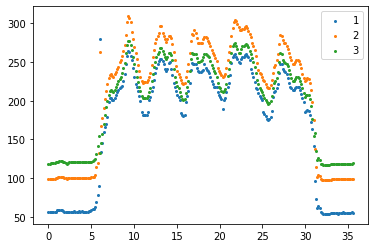

In [9]:
bar_height_guess = 24

bars = [bar_1, bar_2, bar_3]
ind = 1
for bar in bars:
  bar_heights = []
  for im in tqdm(imgs):
    im = lib.remove_background(im, im_background)
    im = lib.preprocess(im)

    correlation, bar_ind_y = get_features_bar(im, bar)

    bar_heights.append(np.argmax(correlation))

  duration = len(imgs)/desired_fps
  t = np.linspace(0, duration, len(bar_heights))
  plt.scatter(t, bar_heights, label = str(ind), s=4)
  ind += 1
plt.legend()

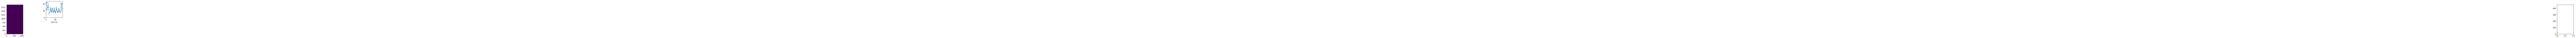

In [11]:
bar_height_guess=24

fig = plt.figure()

ax1 = plt.subplot(1, 3, 1)
im = lib.preprocess(im_background)
ax1_im = ax1.imshow(im_background, cmap='viridis', origin='lower')
ax1_plt = ax1.scatter(0, 0, c='r', marker='_')

ax2 = plt.subplot(2, 3, 3)

ax2_plt = ax2.scatter(0, 0, s=4)#t, bar_heights, s=4)
plt.xlim([0, len(imgs)/desired_fps])
plt.ylim([0, bar_height_guess*2])
plt.xlabel('time (s)')

ax3 = plt.subplot(1, 3, 2)
ax3_plt = ax3.scatter(0, 0, s=4)#t, bar_heights, s=4)

plt.xlim([0, 1])

height = ax1.get_position().ymax-ax1.get_position().ymin
width = ax3.get_position().xmax-ax3.get_position().xmin
left = ax3.get_position().xminduration = len(imgs)/desired_fps
t = np.linspace(0, duration, len(bar_heights))
plt.scatter(t, bar_heights)
bottom = ax1.get_position().ymin

ax3.set_position((left, bottom, width, height))

ts = [0]
bar_heights = [bar_height_guess]

def animate(i):
  global ts, desired_fps, bar_heights
  im = imgs[i]

  im = lib.remove_background(im, im_background)
  im = lib.preprocess(im)
  ax1_im.set_data(im)
  
  
  
  
  correlation, bar_ind_y_top, bar_ind_y_bottom, bar_ind_x, bar_height = lib. get_features_minimal(im, bar_height_guess)
  bar_ind_y = bar_ind_y_top, bar_ind_y_bottom
  ax1_plt.set_offsets(np.c_[[bar_ind_x, bar_ind_x], bar_ind_y])

  bar_heights.append(bar_height)
  ts.append(ts[-1]+1/desired_fps)
  
  ax2_plt.set_offsets(np.c_[ts, bar_heights])
  ax3_plt.set_offsets(np.c_[correlation, np.arange(len(correlation))])
  plt.gca().set_ylim([0, len(correlation)])
  

  return [ax1_im, ax1_plt, ax2_plt, ax3_plt]

ani = animation.FuncAnimation(fig, animate, frames=len(imgs), interval=1/desired_fps*1000, blit=True)
ani.save('animation.mp4')